**GETTING AND UNDERSTANDING YOUR DATASETS**

In [1]:
!pip install -q datasets # installing huggings face dataset

In [2]:
from datasets import load_dataset # to read and load cdatasets
emotions = load_dataset("emotion") ## assigning emotion dataset to emotions variable

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_set = emotions['train'] ## setting the train dataset in the dict to train_set
train_set

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
train_set[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [6]:
##converting dataset to dataframe
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
##getting the label of classification
def label_converter(row):
  return emotions['train'].features['label'].int2str(row)
df['label_name'] = df['label'].apply(label_converter)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


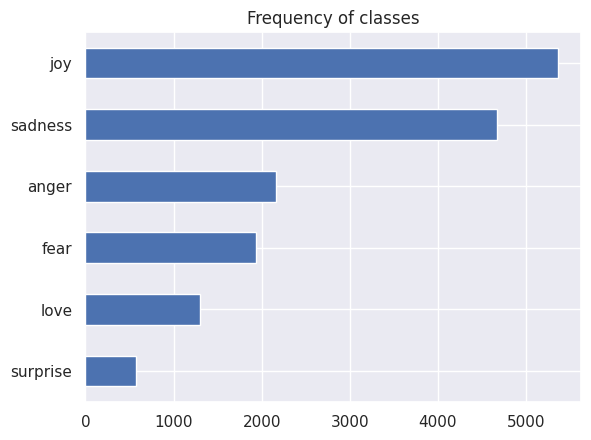

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title('Frequency of classes')
plt.show()



In [9]:
emotions.reset_format() ## to balance datasets

**DATA PREPROCESSING,(TOKENIZATION)**

In [10]:
!pip install -q transformers -U

In [11]:
## Using distillBERT model for tokenization
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)



def tokenize_function(batch):  # applying tokenizer to a batch of data
  return tokenizer(batch["text"], padding =True, truncation =True) #padding will pad the data with zeros to the size of the longest one in a batch
  # truncation will truncate the examples to the models max content size


In [12]:
print(tokenize_function(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [13]:
tokenized_datasets = emotions.map(tokenize_function,
                                  batched = True,
                                  batch_size = None)

In [14]:
print(tokenized_datasets['train'].column_names) ##input_ids represent numeric representation of tokens,
#attentionmask used in model to ignore padded areas of dataset

['text', 'label', 'input_ids', 'attention_mask']


**MODELLING(DistillBert)**

In [15]:
## Using a pretrained model, DistillBERT

from transformers import AutoModelForSequenceClassification
import torch


checkpoint = "distilbert-base-uncased"
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                            num_labels = 6).to(device))



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1. Performance Metrics(Loss Function):Creating the compute_metrics object

In [16]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [17]:
## logging in the huggings face hub to get API key
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
! pip install -U accelerate


In [ ]:
! pip install -U transformers

In [18]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.38.2', '0.28.0')

In [ ]:
## to restart kernel
import os
os._exit(00)

2. SPECIFYING PARAMETERS FOR TRAINING THE MODEL: Creating Trainer Arguments/Parameters Objects

In [19]:
## specifying parameters for training model
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="finetuning-emotion-model",
    num_train_epochs = 2,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    push_to_hub = True,
    report_to = "none"
)

3. CREATING THE TRAINER OBJECT FOR TRAINING

In [21]:
from transformers import Trainer


trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['validation'],
    tokenizer = tokenizer
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


4. TRAINING OR FINETUNING AN ALREADY PRETRAINED MODEL FOR SENTIMENT ANALYSIS

In [ ]:
trainer.train()

In [23]:
## saving model to hugging face hub
trainer.push_to_hub(commit_message = "Training completed")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/sirjosephenry/finetuning-emotion-model/commit/2869ffca5603e649526cf04896841133ccba8b89', commit_message='Training completed', commit_description='', oid='2869ffca5603e649526cf04896841133ccba8b89', pr_url=None, pr_revision=None, pr_num=None)

**PUSHING MODEL TO PIPELINE(API) FOR CLASSIFICATION**

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification",
                      model= "sirjosephenry/finetuning-emotion-model"
                      )

**CLASSIFYING TEXT BASED ON SENTIMENTS**

In [ ]:
pred = classifier(["i love joseph"],
                  return_all_scores = True)

**PLOT PROBABILITY OF EACH CLASS IN A BAR PLOT**

In [ ]:
import pandas as pd

labels = emotions["train"].features["label"].names
df = pd.DataFrame(pred[0])
plt.bar(labels, 100*df["score"])
plt.show()